## 分析準備：アプリごとの売上基本統計の算出



### 1.1. ライブラリのインポートとデータの読み込み

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# フォント設定
plt.rcParams["font.family"] = "Meiryo"

mean_filled_df = pd.read_csv("merged_filled.csv", encoding="utf-8-sig")

# 日付型に変換(CSVに書き出すと文字列に戻るから)
mean_filled_df["サービス開始日"] = pd.to_datetime(mean_filled_df["サービス開始日"], errors="coerce")
mean_filled_df["サービス終了日"] = pd.to_datetime(mean_filled_df["サービス終了日"], errors="coerce")
mean_filled_df["年月"] = pd.to_datetime(mean_filled_df["年月"], errors="coerce")


### 1.2. IP/非IP分類のための関数と適用

In [4]:
def classify_ip(text):
    if pd.isna(text):
        return "非IP"
    keywords = ["原作", "アニメ", "コミック", "漫画", "マンガ", "小説"]
    if any(keyword in text for keyword in keywords):
        return "IP"
    return "非IP"

mean_filled_df["分類"] = mean_filled_df["備考"].apply(classify_ip)

# タイトル単位で集計（備考は除外）
app_sales_summary = (
    mean_filled_df.groupby("タイトル", as_index=False)
    .agg({
        "売上予測（円）": ["sum", "mean"],
        "サービス開始日": "first",
        "サービス終了日": "first",
        "分類": "first"
    })
)

# カラム名を整形
app_sales_summary.columns = [
    "タイトル", "売上合計", "平均売上", "サービス開始日", "サービス終了日", "分類"
]

# サービス継続日数を計算して追加（NaT同士ならNaNになります）
app_sales_summary["サービス継続月数"] = (
    app_sales_summary["サービス終了日"] - app_sales_summary["サービス開始日"]
).dt.days // 30

# 保存
app_sales_summary.to_csv("app_sales_summary.csv", index=False, encoding="utf-8-sig")

### 1.3. 非IPからIPの売上合計の最小値以下のデータを除外し確認

In [6]:
# CSVファイルの読み込み
df = pd.read_csv("app_sales_summary.csv")

# IPの売上合計の最小値を取得
ip_min_sales = df[df["分類"] == "IP"]["売上合計"].min()

# 除外前の非IP件数
non_ip_before = len(df[df["分類"] == "非IP"])

# 非IPのうち、売上合計がIPの最小値以下のものを除外
filtered_df = df[~((df["分類"] == "非IP") & (df["売上合計"] <= ip_min_sales))]

# 除外後の非IP件数
non_ip_after = len(filtered_df[filtered_df["分類"] == "非IP"])

# 結果を表示
print(f"非IP件数（除外前）: {non_ip_before}")
print(f"非IP件数（除外後）: {non_ip_after}")

非IP件数（除外前）: 282
非IP件数（除外後）: 276


### 1.4. IP/非IP のアプリ別売上合計の分布を可視化

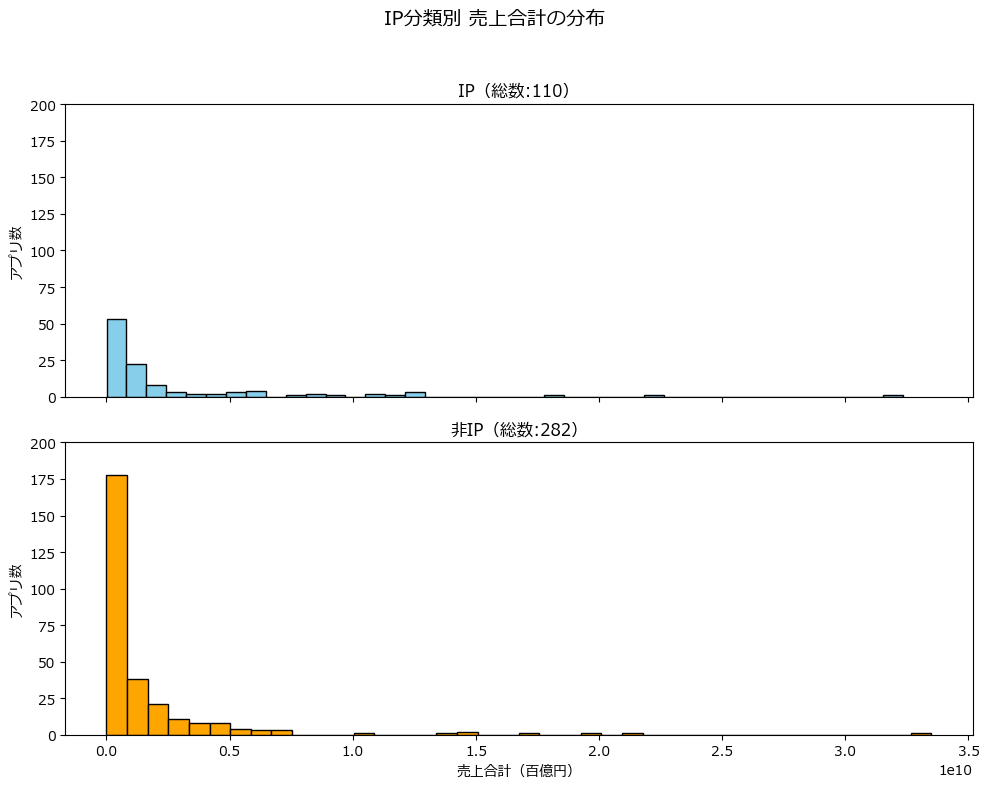

In [15]:
ip_apps = app_sales_summary[app_sales_summary["分類"] == "IP"]
non_ip_apps = app_sales_summary[app_sales_summary["分類"] == "非IP"]

# サブプロットの作成（上下2段）
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# IPのヒストグラム（上段）
axes[0].hist(ip_apps["売上合計"], bins=40, color="skyblue", edgecolor="black")
axes[0].set_title(f"IP（総数:{len(ip_apps)}）")
axes[0].set_ylabel("アプリ数")
axes[0].set_ylim(0, 200)

# 非IPのヒストグラム（下段）
axes[1].hist(non_ip_apps["売上合計"], bins=40, color="orange", edgecolor="black")
axes[1].set_title(f"非IP（総数:{len(non_ip_apps)}）")
axes[1].set_xlabel("売上合計（百億円）")
axes[1].set_ylabel("アプリ数")
axes[1].set_ylim(0, 200)

# 全体のタイトルとレイアウト調整
fig.suptitle("IP分類別 売上合計の分布", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 表示
plt.show()


In [16]:
# 非IPの売上合計データ
non_ip_sales = non_ip_apps["売上合計"]

# ヒストグラムのbinとカウントを取得
counts, bin_edges = np.histogram(non_ip_sales, bins=40)

# 1本目のbinに入っているデータ数（最も左）
first_bin_count = counts[0]
first_bin_range = (bin_edges[0], bin_edges[1])

print(f"1本目のbinの範囲: {first_bin_range}")
print(f"1本目のbinに入っている非IPアプリ数: {first_bin_count}")


1本目のbinの範囲: (np.float64(1200000.0), np.float64(838437714.2857143))
1本目のbinに入っている非IPアプリ数: 178
